# Predicting JunD binding

In this use case we compare different models using different input features to predict the binding of the JunD transcription factor.

In [1]:
#!pip install rpy2
#!pip install tzlocal
#!conda install --yes -c bioconda bedtools samtools
#!conda install --yes r-ggplot2

In [2]:
import os
%load_ext rpy2.ipython

from IPython.display import Image

In [3]:
datadir = '../data'
outputdir = '../jund_results'

In [4]:
%R library(ggplot2)

array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

Run a grid search for a DNA only model.
(Since the following parts are rather time consuming, they will be reran only if you remove the hashtags).

In [5]:
#!python dna_only.py -inputpath {datadir} -path {outputdir}

Run a grid search on a DNase only model

In [6]:
#!python dnase_only.py -inputpath {datadir} -path {outputdir}

Fit models that use DNA and DNase as input simultaneously

In [7]:
#!python dnase_dna_model.py -inputpath {datadir} -path {outputdir}

Finally, the following script produces a few sample plots using the plotGenomeTrack functionality.

In [8]:
#!python plot_dnase_dna.py -inputpath {datadir} -path {outputdir}

Illustration of an example genomic locus. The figure shows the concordance between the ground truth JunD bound region and the predicted binding site. Underneath, the DNase coverage is shown for thtwo samples.

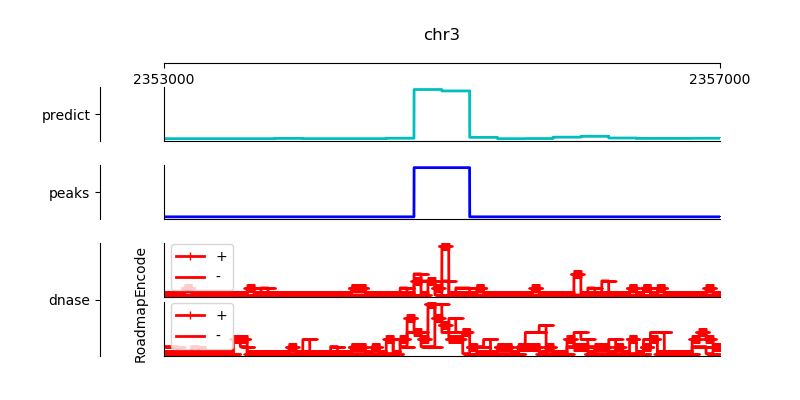

In [9]:
Image(os.path.join(outputdir, 'jund_input_outout_line.png'))

Illustration of input feature importance discovered by integrated gradients. The site in the center which is highlighted as being important closely resembles as JunD binding motif.

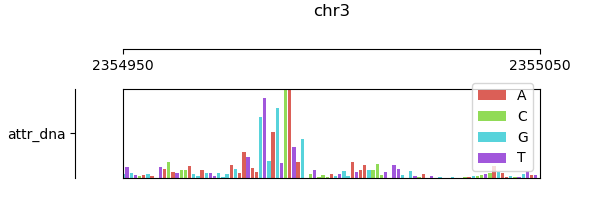

In [10]:
Image(os.path.join(outputdir, 'jund_input_attribution_dna.png'))

The overall performances using only the DNA sequence as input shows that the use of higher order features improves the prediction quality.

In [5]:
results = os.path.join(outputdir, 'dna_gridsearch_5.tsv')

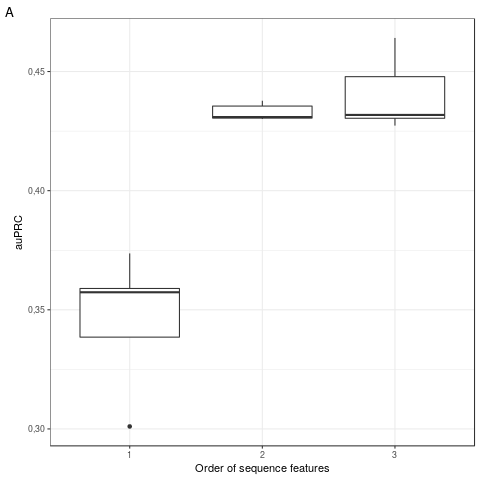

In [8]:
%%R -i results

dna = read.table(results)
#print(aggregate(dna[,2], list(dna[,3], dna[,4]), median))

g1 = ggplot(subset(dna, dropout==0.0), aes(x=as.factor(order), y=auprc_val)) + geom_boxplot() + xlab("Order of sequence features") + ylab("auPRC") + theme_bw() +labs(tag="A")
print(g1)

In [9]:
figure = os.path.join(outputdir, 'dna_gridsearch.png')

%R -i figure ggsave(figure, height=4, width=3)

Furthermore, by using a dropout at the initial layer a slight performance improvement is obtained from tri-nucleotide based sequence encoding.

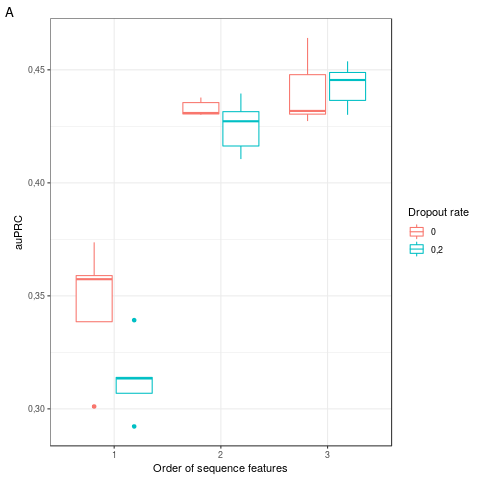

In [11]:
%%R
g1 = ggplot(dna, aes(x=as.factor(order), y=auprc_val, color=as.factor(dropout))) + 
   geom_boxplot() + xlab("Order of sequence features") + 
    ylab("auPRC") + guides(color=guide_legend(title="Dropout rate")) + 
    theme_bw() + labs(tag="A")
print(g1)

In [12]:
figure = os.path.join(outputdir, 'dna_gridsearch_drop.png')
%R -i figure ggsave(figure, height=4, width=3)

Next, we explore the JunD predictions when only DNase-seq coverage is used as input. In particular, we investigate the effect of data normalization and augmentation.

In [19]:
dnaseresults = os.path.join(outputdir, "dnase_gridsearch_7.tsv")

In [20]:
%%R -i dnaseresults

dnase = read.table(dnaseresults, stringsAsFactors = F)
dnase$augment[dnase$augment=="orient"] = "Flip orientation"
dnase$augment[dnase$augment=="none"] = "None"
dnase$normalize[dnase$normalize=="tpm"] = "TPM"
dnase$normalize[dnase$normalize=="none"] = "None"
dnase$normalize[dnase$normalize=="zscorelog"] = "Z-score of log-counts"



Data normalization using transcripts-per-million (TPM) or Z-Score after log-transformation of the counts both improve the prediction accuracy considerably compared to not using normalization.
Furthermore, data augmentation by flipping 5' to 3' orientations of the coverage tracks further improves the results.

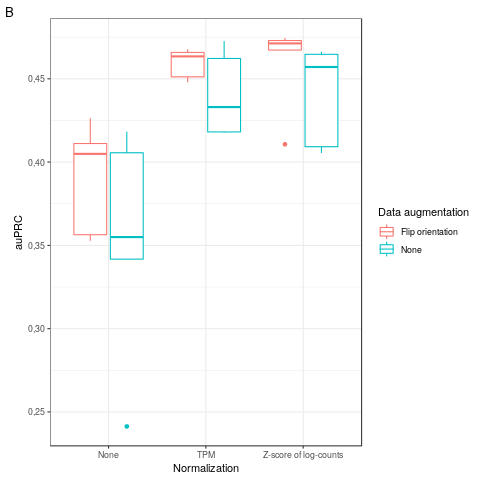

In [21]:
%%R
g2=ggplot(subset(dnase, normalize!="zscore"), aes(x=normalize, y=auprc_test, color=augment)) + 
 geom_boxplot() + xlab("Normalization") + 
  ylab("auPRC") + 
  guides(color=guide_legend(title="Data augmentation")) + theme_bw() +   labs(tag="B")
print(g2)

In [23]:
figure = os.path.join(outputdir, "dnase_gridsearch.png")
%R -i figure ggsave(figure, height=4, width=6)

Finally, we use a model that takes DNA and DNase-seq as input for the prediction of JunD. This model obtains superior performance compared to using either input separately for the prediction.

In [24]:
randres =  os.path.join(outputdir, "dnase_dna_use_randominit_submodels.tsv")

In [25]:
%R -i randres df = read.table(randres, stringsAsFactors = F)

,auprc_val,auprc_test
0,0.693194,0.675581
1,0.709087,0.702321
2,0.693212,0.672333
3,0.681510,0.672720
4,0.703246,0.693258


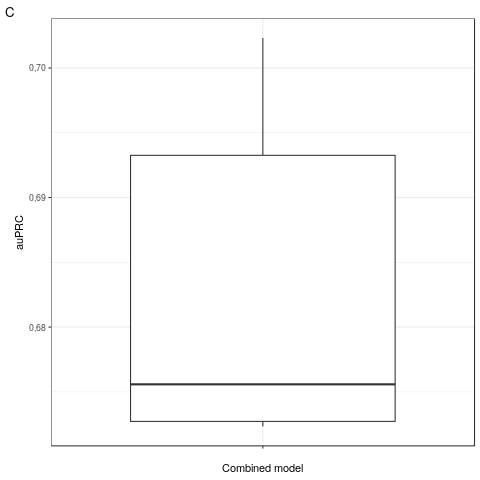

In [27]:
%%R

df$init = ""

g3 <- ggplot(df, aes(x=init, y=auprc_test)) + geom_boxplot() +  xlab("Combined model") + ylab("auPRC") + theme_bw() + labs(tag="C")

print(g3)

In [28]:
figure =  os.path.join(outputdir, "dna_dnase_joint.png")
%R -i figure ggsave(figure, height=4, width=2)